In [1]:
import random
import warnings
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")

In [2]:
features, target = load_breast_cancer(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=1)
print(X_train.shape)
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

pipeline.fit(X_train, y_train)

(398, 30)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [3]:
features.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [4]:
# calculate the shaply value for feature j
j = 15
M = 5000
sample_idx = 0
x = X_test.iloc[sample_idx]
n_features = len(x)
marginal_contributions = []
feature_idxs = list(range(n_features))
feature_idxs.remove(j)
for _ in range(M):
    z = X_train.sample(1).values[0]
    x_idx = random.sample(feature_idxs, min(max(int(0.2*n_features), random.choice(feature_idxs)), int(0.8*n_features)))
    z_idx = [idx for idx in feature_idxs if idx not in x_idx]
    #print(x_idx)
    #print(z_idx)
    # construct two new instances
    x_plus_j = np.array([x[i] if i in x_idx + [j] else z[i] for i in range(n_features)])
    x_minus_j = np.array([z[i] if i in z_idx + [j] else x[i] for i in range(n_features)])
    
    # calculate marginal contribution
    marginal_contribution = pipeline.predict_proba(x_plus_j.reshape(1, -1))[0][1] - pipeline.predict_proba(x_minus_j.reshape(1, -1))[0][1]
    marginal_contributions.append(marginal_contribution)
    
phi_j_x = sum(marginal_contributions) / len(marginal_contributions)  # our shaply value
print(f"Shaply value for feature j: {phi_j_x.round(5)}")


Shaply value for feature j: 0.07928


In [12]:
import shap
j=15
explainer_ex = shap.Explainer(pipeline.predict_proba, X_train)
shap_values_ex = explainer_ex(X_test)
print(type(shap_values_ex))
print(np.array(shap_values_ex).shape)
print(shap_values_ex[0,j,1])#(class,obs,특성변수)
print('------------------------------')
print(shap_values_ex[0,j,:].values)
print(shap_values_ex[0,j,:].base_values)
print(shap_values_ex[0,j,:].data)

<class 'shap._explanation.Explanation'>
(171, 30, 2)
.values =
0.07876485439245981

.base_values =
0.6431530689686977

.data =
0.05244
------------------------------
[-0.07876485  0.07876485]
[0.35684693 0.64315307]
0.05244


In [19]:
import shap
j=15
explainer_ex = shap.Explainer(pipeline.predict_proba, X_train)
shap_values_ex = explainer_ex(X_test[0:1])
print(type(shap_values_ex))
print(np.array(shap_values_ex).shape)
print(shap_values_ex[0,j,1])#(class,obs,특성변수)
print('------------------------------')
print(shap_values_ex[0,j,:].values)
print(shap_values_ex[0,j,:].base_values)
print(shap_values_ex[0,j,:].data)

<class 'shap._explanation.Explanation'>
(1, 30, 2)
.values =
0.10737493137818063

.base_values =
0.6431530689686977

.data =
0.05244
------------------------------
[-0.10737493  0.10737493]
[0.35684693 0.64315307]
0.05244


In [16]:
explainer = shap.KernelExplainer(pipeline.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
expected=explainer.expected_value
print(type(expected))
print(expected.shape)
print(expected)
print('------------------------------')
print(type(shap_values))
print(np.array(shap_values).shape)
print(shap_values[1][0,j])#(class,obs,특성변수)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/171 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
(2,)
[0.3743709 0.6256291]
------------------------------
<class 'list'>
(2, 171, 30)
0.08424557980752842


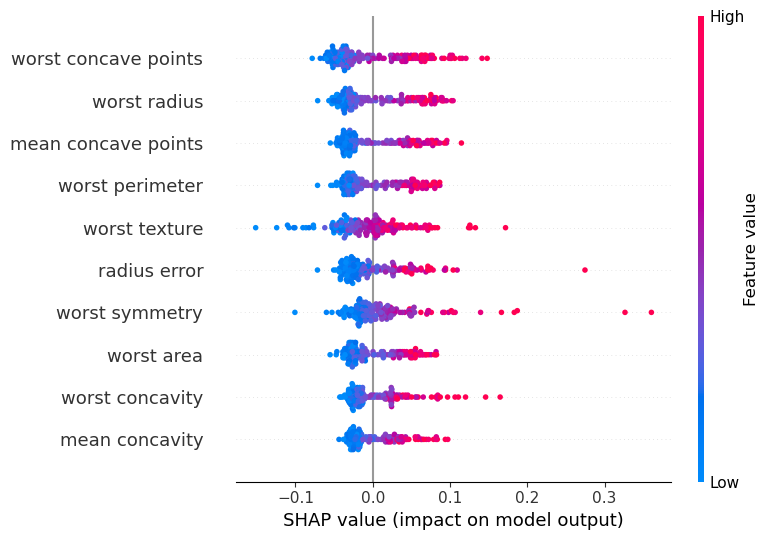

In [7]:
shap.summary_plot(shap_values_ex[:,:,0],features=X_test, max_display=10)

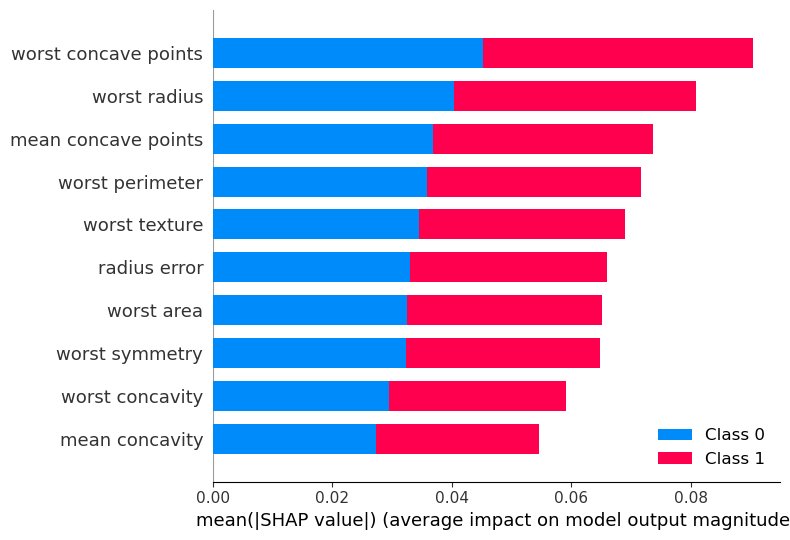

In [8]:
shap.summary_plot(shap_values,features=X_test, max_display=10)

In [10]:
print(X_test.iloc[0])
print(shap_values[0][0,:])

mean radius                 14.690000
mean texture                13.980000
mean perimeter              98.220000
mean area                  656.100000
mean smoothness              0.103100
mean compactness             0.183600
mean concavity               0.145000
mean concave points          0.063000
mean symmetry                0.208600
mean fractal dimension       0.074060
radius error                 0.546200
texture error                1.511000
perimeter error              4.795000
area error                  49.450000
smoothness error             0.009976
compactness error            0.052440
concavity error              0.052780
concave points error         0.015800
symmetry error               0.026530
fractal dimension error      0.005444
worst radius                16.460000
worst texture               18.340000
worst perimeter            114.100000
worst area                 809.200000
worst smoothness             0.131200
worst compactness            0.363500
worst concav

In [11]:
shap.force_plot(explainer.expected_value[0],shap_values[0][0,:],features=X_test.iloc[0,:])

In [12]:
shap.force_plot(explainer.expected_value[1],shap_values[1][0:5,:],features=X_test.iloc[0:5,:])

In [13]:
shap.force_plot(explainer.expected_value[1],shap_values[1],features=X_test)

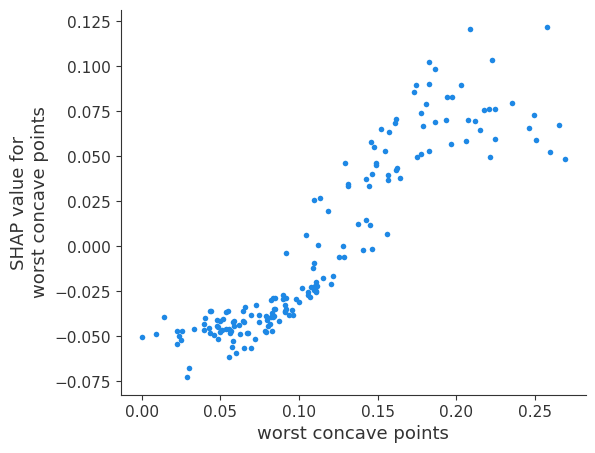

In [14]:
shap.dependence_plot('worst concave points', shap_values[0], features=X_test,interaction_index=None)

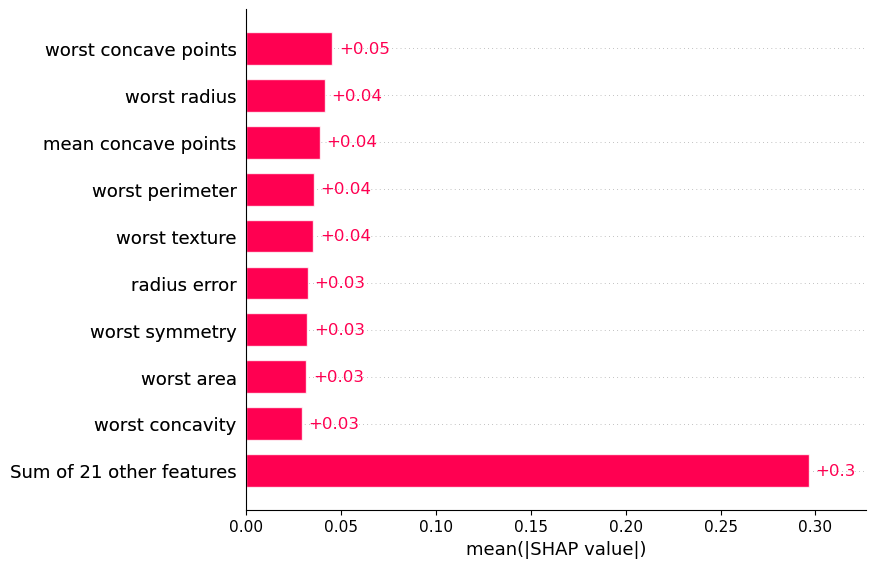

In [15]:
shap.plots.bar(shap_values_ex[:,:,0])

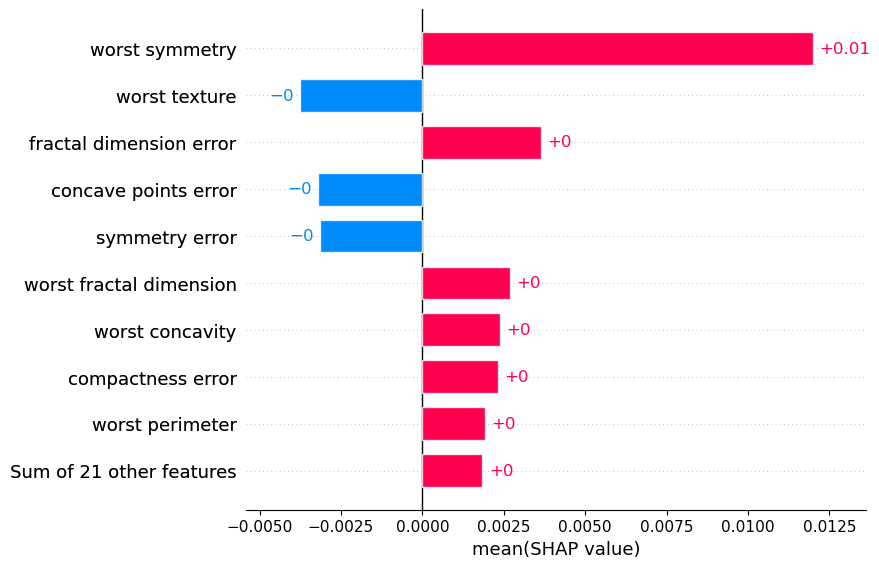

In [16]:
shap.plots.bar(shap_values_ex[:,:,0].mean(axis=0))

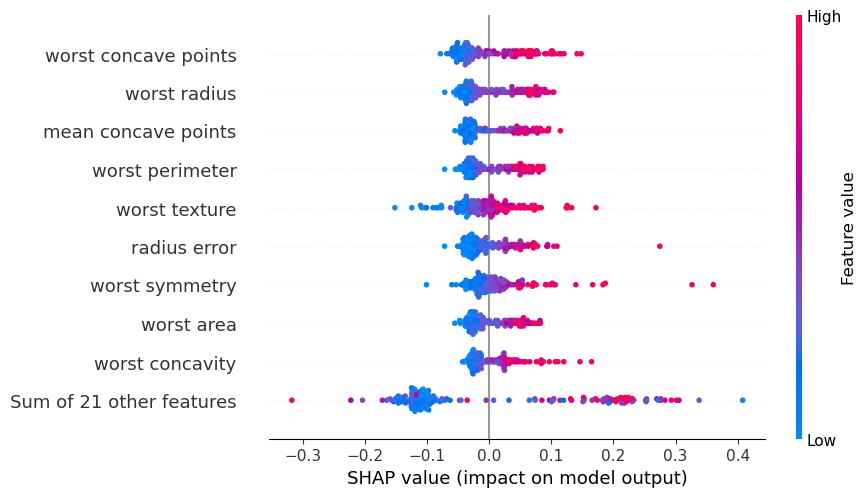

In [17]:
shap.plots.beeswarm(shap_values_ex[:,:,0])

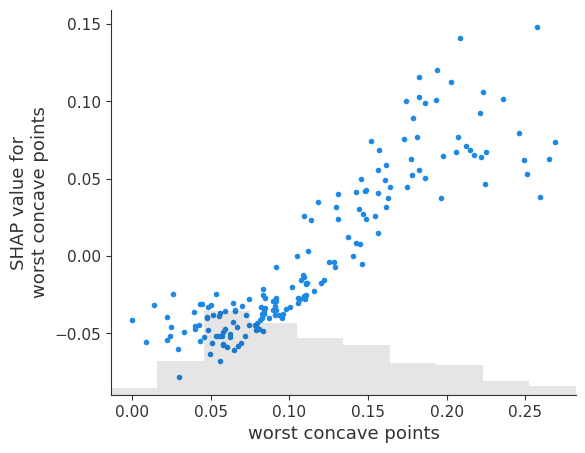

In [18]:
shap.plots.scatter(shap_values_ex[:,"worst concave points",0])

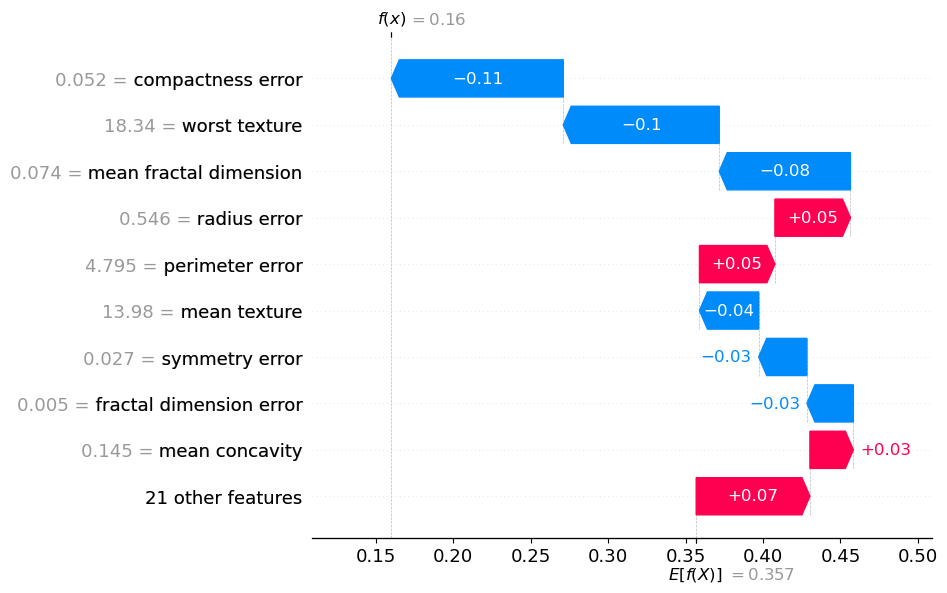

In [19]:
shap.plots.waterfall(shap_values_ex[0,:,0])

In [20]:
shap.plots.force(shap_values_ex[0,:,0])

In [20]:
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# California Housing Prices
dataset = fetch_california_housing(as_frame = True)
X = dataset['data']
y = dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model_reg=LinearRegression()
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)
model_reg.fit(X_train,y_train)

LinearRegression()

In [21]:
print(X_train.columns)
print(model_reg.coef_)
explainer_reg=shap.Explainer(model_reg.predict,X_train)
shap_reg=explainer_reg(X_train)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
[ 4.39394856e-01  9.19927827e-03 -1.14630827e-01  6.46071214e-01
 -6.77136345e-06 -3.43948606e-03 -4.17950962e-01 -4.31028175e-01]


Exact explainer: 16513it [01:50, 136.44it/s]                                                                           


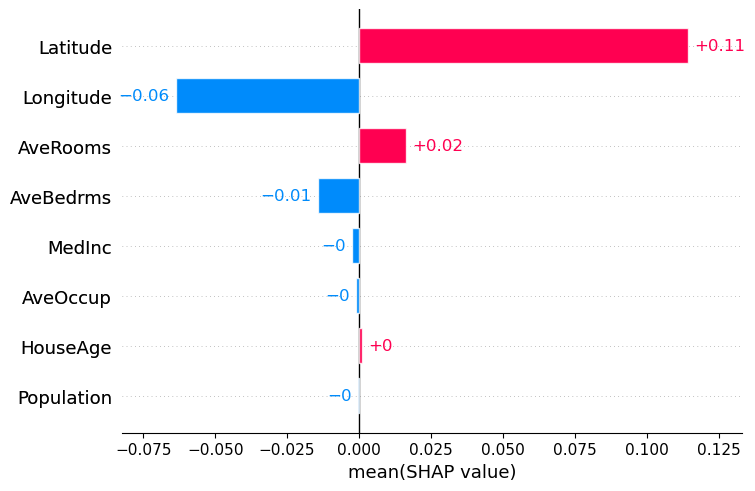

In [22]:
shap.plots.bar(shap_reg.mean(axis=0))

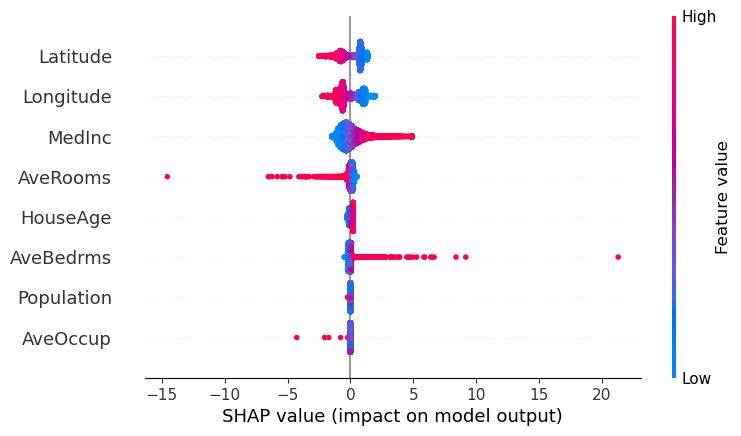

In [23]:
shap.plots.beeswarm(shap_reg)

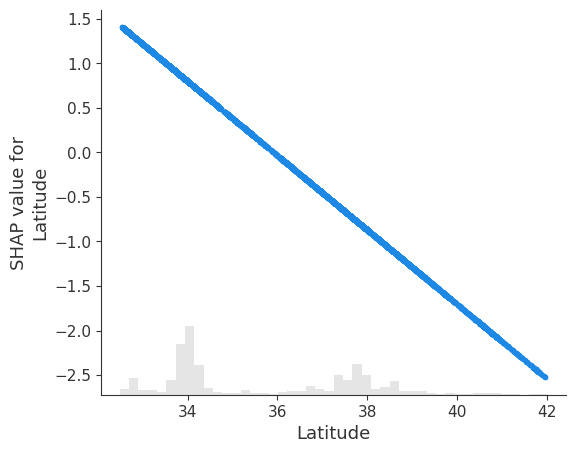

In [24]:
shap.plots.scatter(shap_reg[:,'Latitude'])

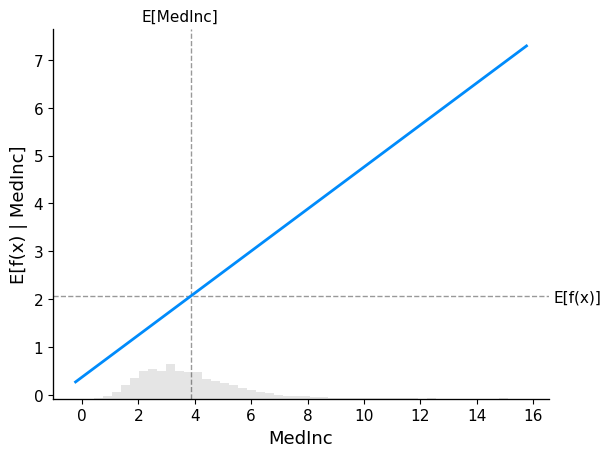

In [25]:
shap.partial_dependence_plot(
    "MedInc", model_reg.predict, X_train, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [ ]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_train)
# Calculates the SHAP values - It takes some time
shap_values_test = explainer(X_test)

Exact explainer:  26%|███████████████▉                                             | 1082/4128 [06:00<16:20,  3.11it/s]

In [8]:
print(type(shap_values_test))
print(shap_values_test.shape)

<class 'shap._explanation.Explanation'>
(4128, 8)


In [9]:
import numpy as np
print(len(X_test))
print(np.array(shap_values_test).shape)
print(shap_values_test[0])

4128
(4128, 8)
.values =
array([-0.7394473 ,  0.04323063, -0.05158736, -0.00807891, -0.01179615,
       -0.19686604, -0.44233317, -0.17155112])

.base_values =
2.0965294179999994

.data =
array([ 1.40150000e+00,  3.50000000e+01,  4.09859155e+00,  9.75352113e-01,
        9.92000000e+02,  3.49295775e+00,  3.53500000e+01, -1.19000000e+02])


In [10]:
explainer_kernel = shap.KernelExplainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_kernel = explainer_kernel.shap_values(X_test[0:2])
print(type(shap_values_kernel))
print(np.array(shap_values_kernel).shape)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Using 4128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<class 'numpy.ndarray'>
(2, 8)


In [11]:
print(explainer_kernel.expected_value)

2.0882806429021317


In [12]:
explainer_tree = shap.TreeExplainer(model, X_test)
# Calculates the SHAP values - It takes some time
shap_values_tree = explainer_tree.shap_values(X_test,check_additivity=False)#model.predict를 쓰지못하므로                                                                         
print(shap_values_tree[0])
print(np.array(shap_values_tree).shape)

100%|===================| 4115/4128 [03:20<00:00]        

[-0.71765669  0.02462886 -0.03869511 -0.01484777 -0.01029372 -0.23062408
 -0.59770921  0.02357259]
(4128, 8)


In [13]:
print(type(shap_values_tree))

<class 'numpy.ndarray'>


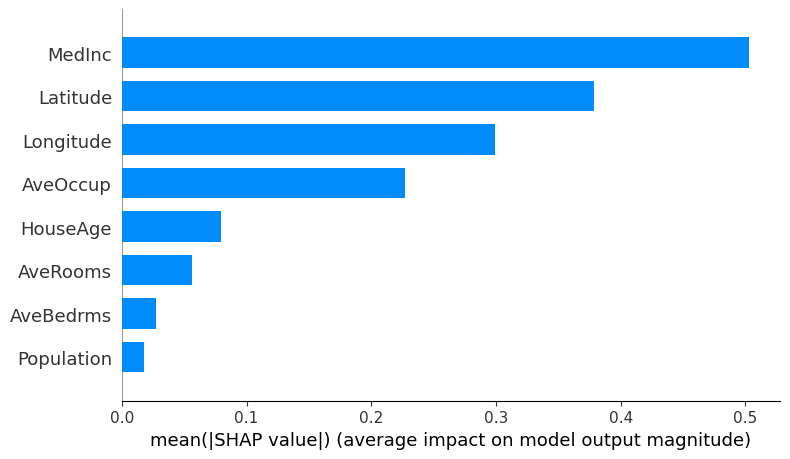

In [14]:
shap.summary_plot(shap_values_tree,features=X_test,plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


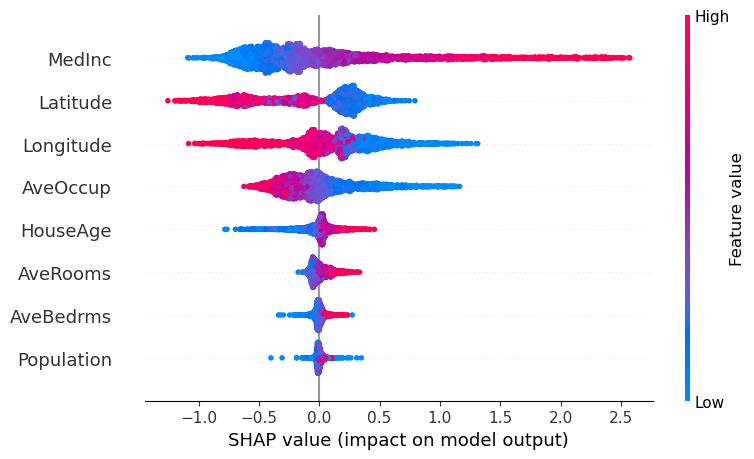

In [15]:
shap.summary_plot(shap_values_tree,features=X_test)

In [18]:
shap.force_plot(explainer_tree.expected_value,shap_values_tree[0],features=X_test.iloc[0,:])

In [19]:
shap.force_plot(explainer_tree.expected_value,shap_values_tree[0:5],features=X_test.iloc[0:5,:])

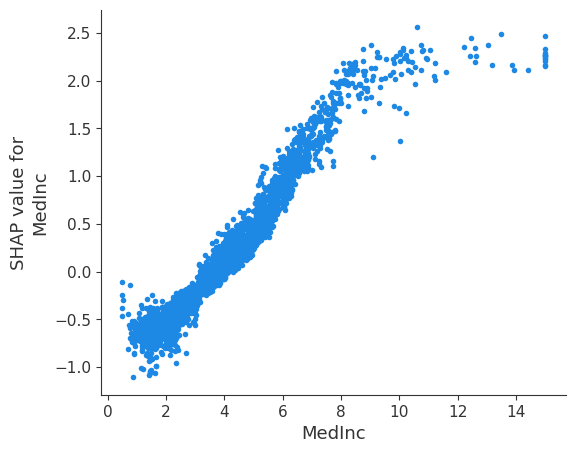

In [49]:
shap.dependence_plot("MedInc", shap_values_tree, features=X_test,interaction_index=None)

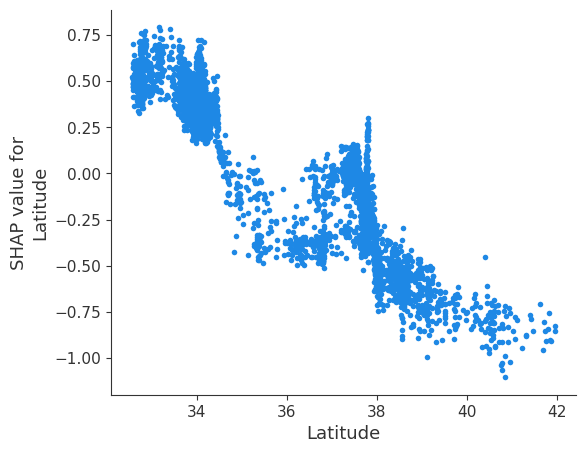

In [50]:
shap.dependence_plot("Latitude", shap_values_tree, features=X_test,interaction_index=None)

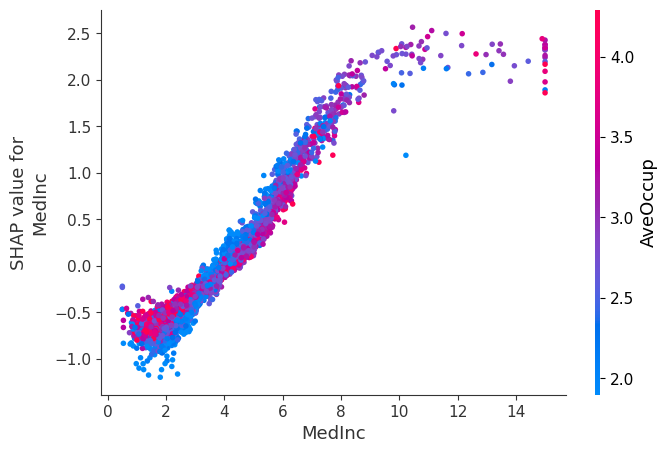

In [34]:
shap.dependence_plot("MedInc", shap_values_tree, features=X_test)

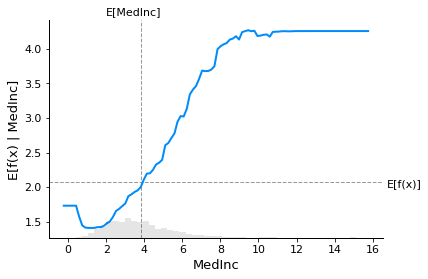

In [17]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X_test, ice=False,
    model_expected_value=True, feature_expected_value=True
)

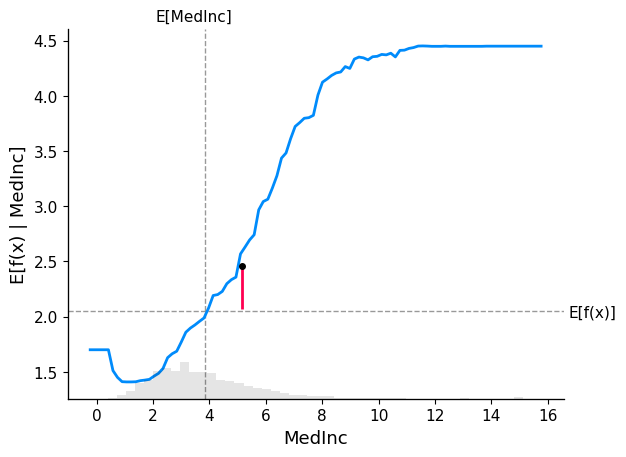

In [58]:
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc", model.predict, X_test, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values_test[sample_ind:sample_ind+1,:]
)

In [23]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
print(X_display.info())
print(X_display[0:10])
print(y_display[0:5])
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             32561 non-null  float32 
 1   Workclass       32561 non-null  category
 2   Education-Num   32561 non-null  float32 
 3   Marital Status  32561 non-null  category
 4   Occupation      32561 non-null  category
 5   Relationship    32561 non-null  category
 6   Race            32561 non-null  category
 7   Sex             32561 non-null  category
 8   Capital Gain    32561 non-null  float32 
 9   Capital Loss    32561 non-null  float32 
 10  Hours per week  32561 non-null  float32 
 11  Country         32561 non-null  category
dtypes: category(7), float32(5)
memory usage: 862.0 KB
None
    Age          Workclass  Education-Num          Marital Status  \
0  39.0          State-gov           13.0           Never-married   
1  50.0   Self-emp-not-inc           13.0      Ma

In [24]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap

In [25]:
from sklearn.metrics import accuracy_score
eval_set = [(X_test, y_test)]
lgb=LGBMClassifier(n_estimators=997, learning_rate=0.05, max_depth=3,colsample_bytree=0.842,
                     min_child_weight=2,subsample=0.448, verbose=0)
model=lgb.fit(X_train,y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [26]:
import numpy as np
explainer = shap.TreeExplainer(model,X_test)
shap_values = explainer.shap_values(X_test)
print(explainer.expected_value)
print(np.array(shap_values).shape)

 98%|===================| 6380/6513 [00:39<00:00]        

-2.3943097047780806
(6513, 12)


In [40]:
shap.initjs()# print the JS visualization code to the notebook
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [41]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


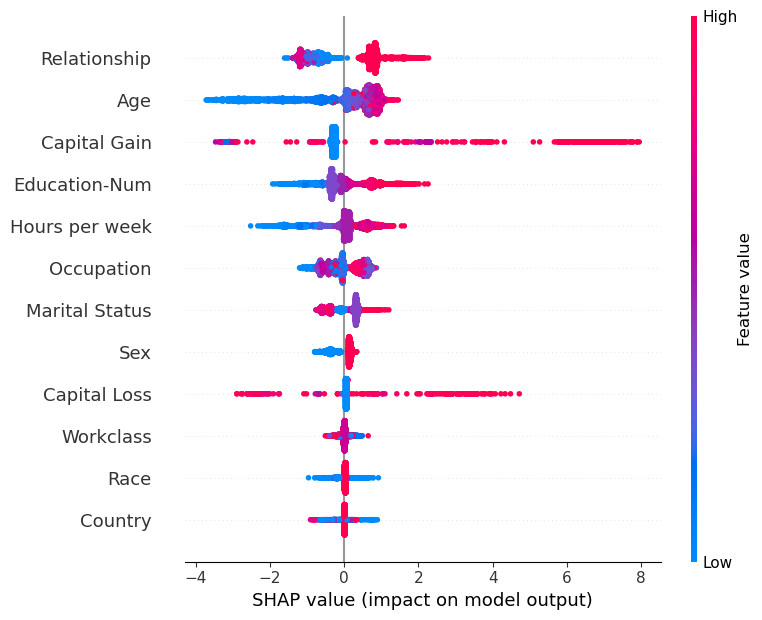

In [42]:
shap.summary_plot(shap_values, X_test)

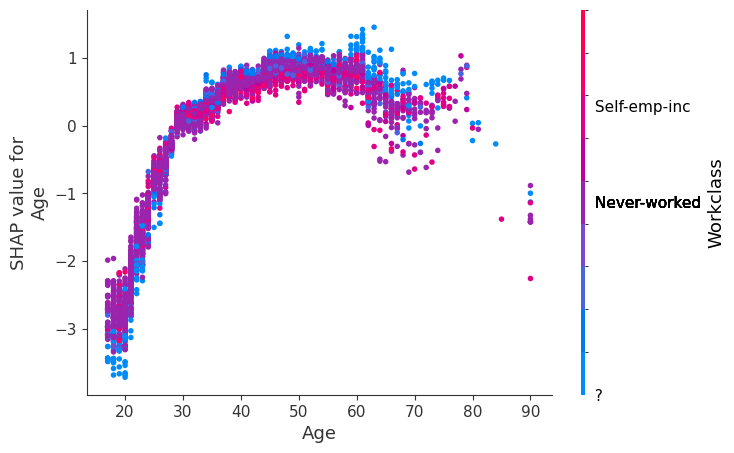

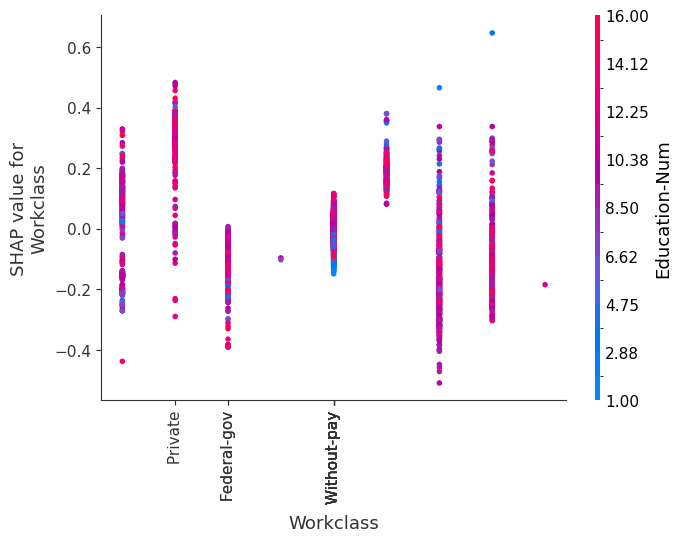

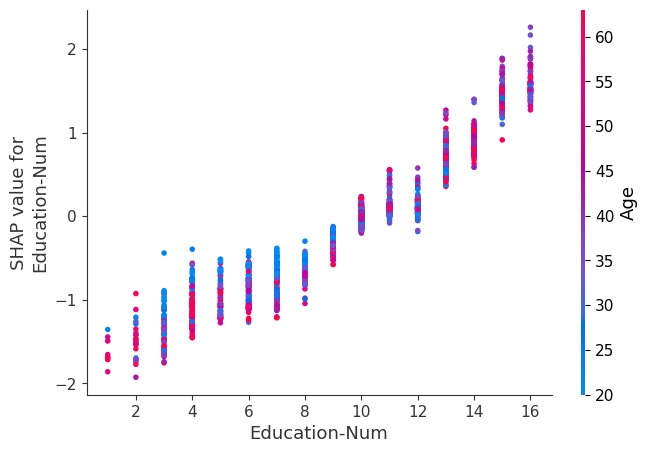

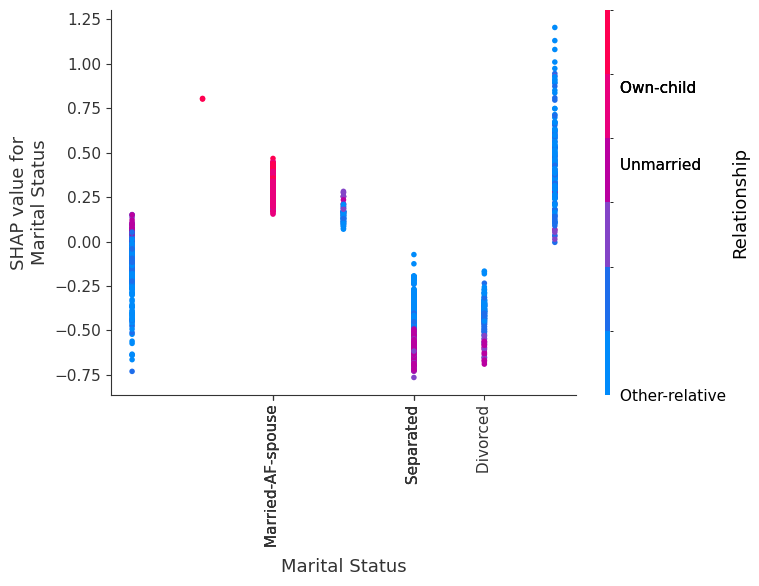

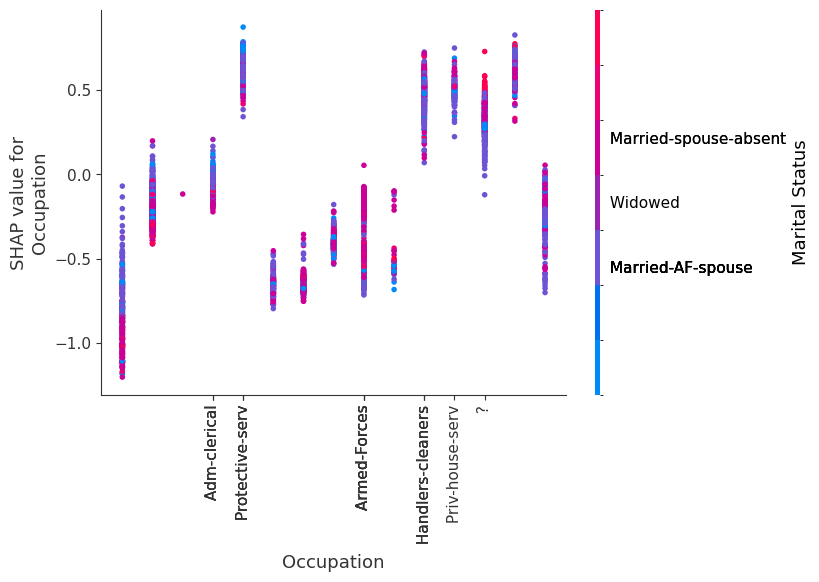

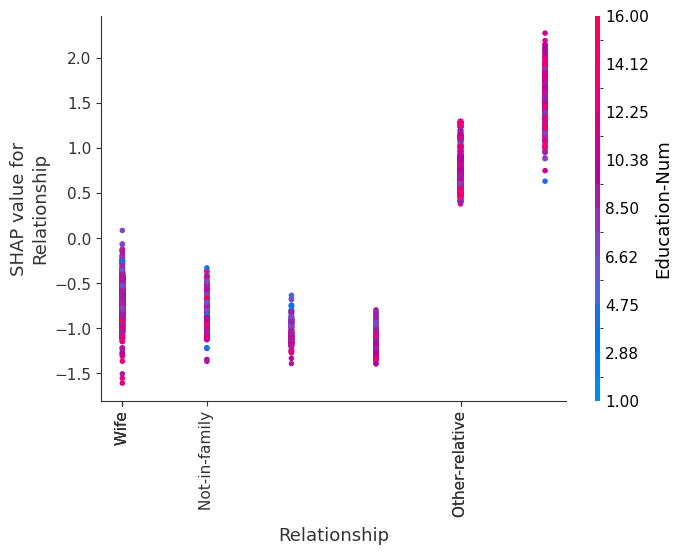

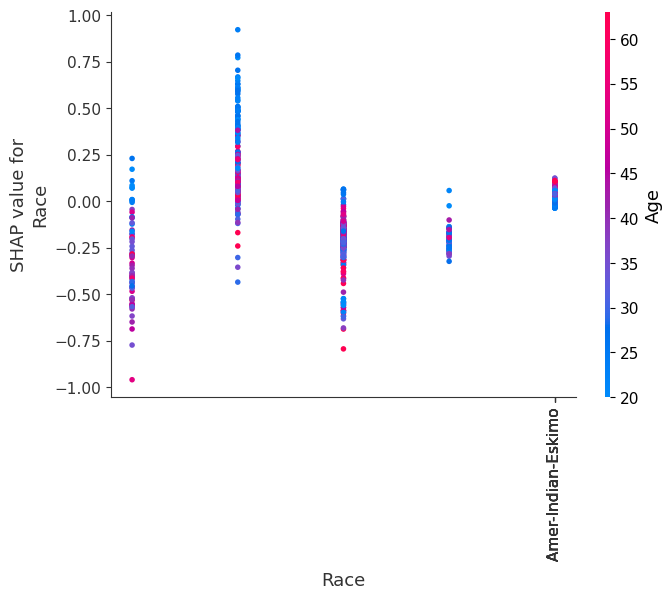

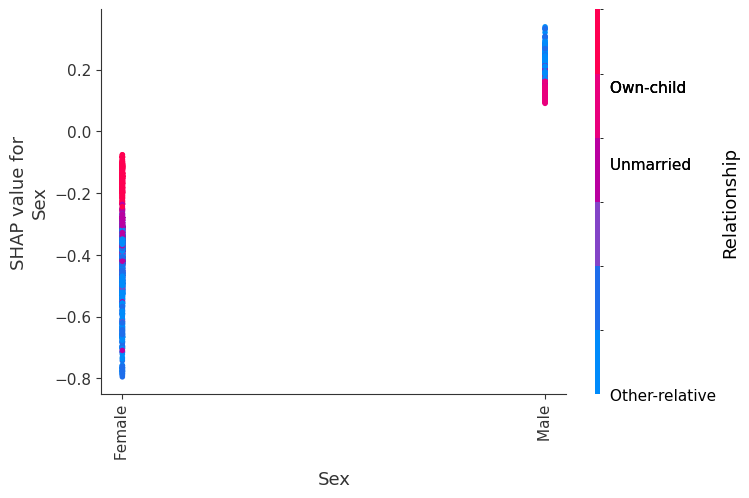

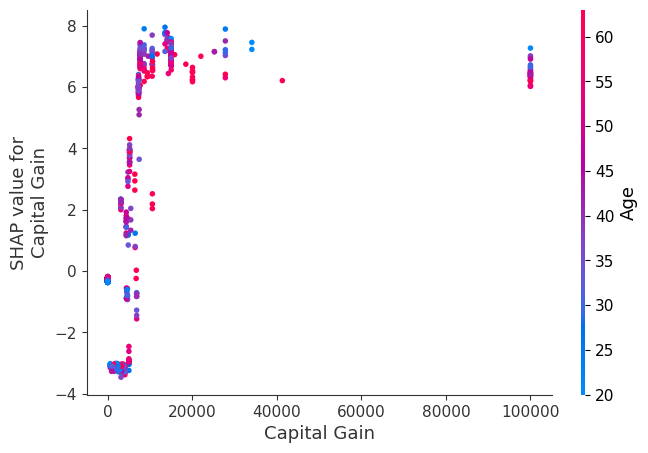

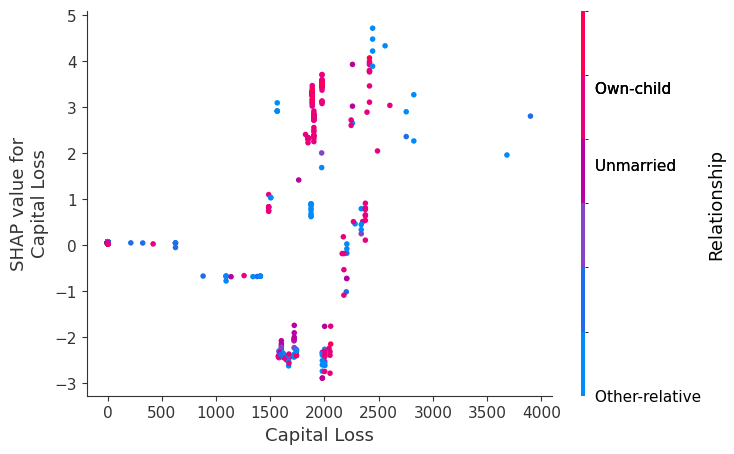

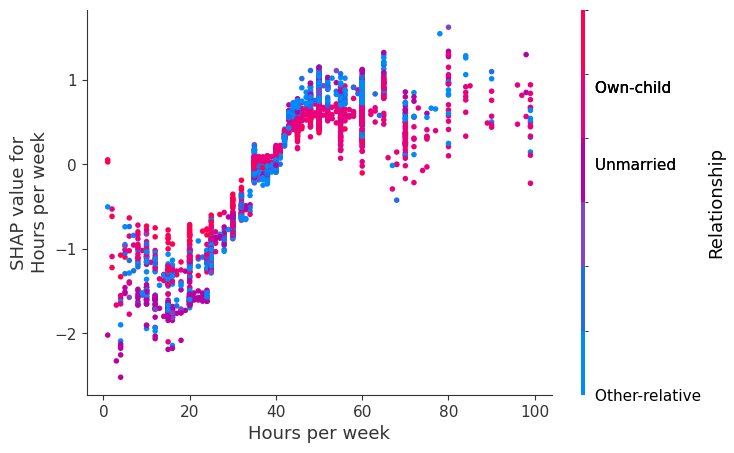

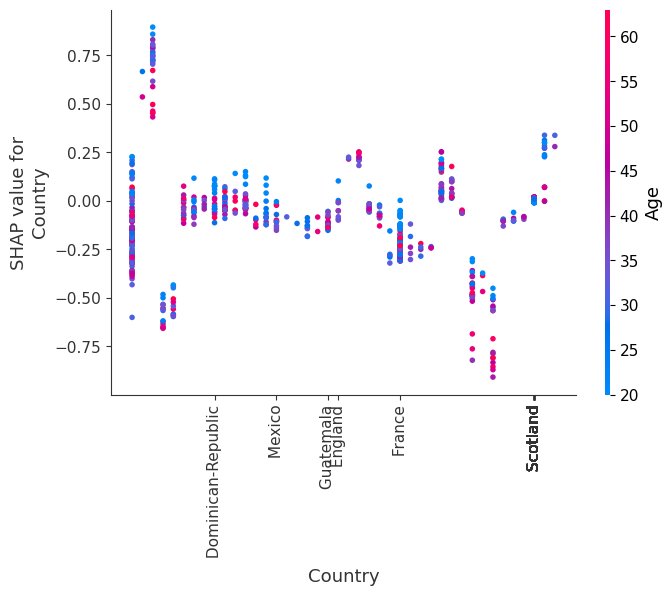

In [43]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_test, display_features=X_display)

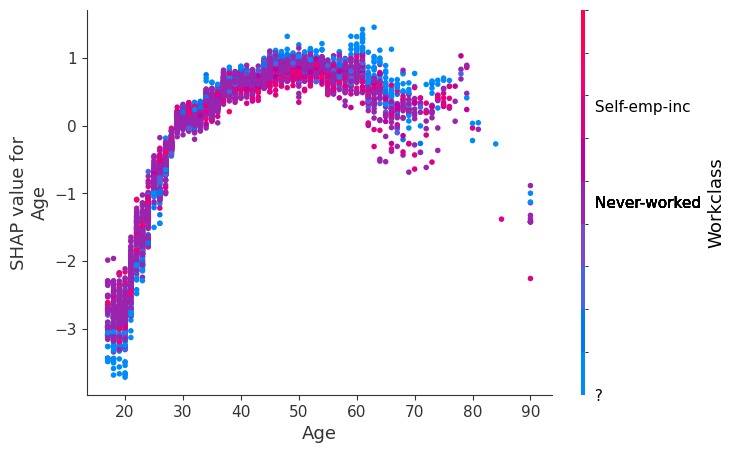

In [27]:
 shap.dependence_plot('Age', shap_values, X_test, display_features=X_display)

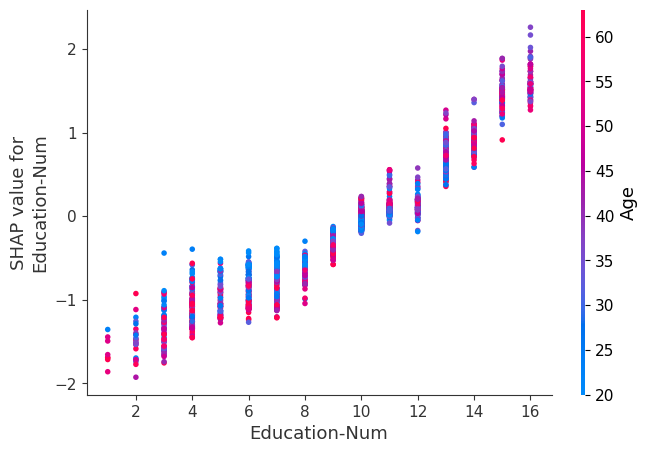

In [30]:
 shap.dependence_plot('Education-Num', shap_values, X_test, display_features=X_display)